Resources:

- https://docs.pytorch.org/docs/stable/generated/torch.nn.LSTM.html
- https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/




#### Dependencies

In [343]:
import os
import re
import json
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr, pearsonr
from pathlib import Path
import numpy as np
import random
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from datetime import datetime, timedelta
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import SMAIndicator, MACD, CCIIndicator
from ta.momentum import WilliamsRIndicator
from ta.volume import ChaikinMoneyFlowIndicator



In [344]:
print(torch.__version__)
print(torch.version.cuda) 
print(torch.cuda.is_available())   # True if a GPU is detected
print(torch.cuda.device_count())   # Number of GPUs available
# print(torch.cuda.get_device_name(0))  # Name of the first GPU

2.9.0+cu128
12.8
True
1


#### Utillity functions

In [345]:
def load_data(
    ticker: str,
    start_date: str,
    end_date: str,
    leadup_days: int = 30,
    interval: str = "1d",
    
):
    """
    Fetches price data with extra leadup_days for indicator warmup,
    computes technical indicators, and trims back to the exact start_date.
    """

    # Compute leadup start date
    start_dt = datetime.strptime(start_date, "%Y-%m-%d")
    leadup_start_dt = start_dt - timedelta(days=leadup_days)
    leadup_start = leadup_start_dt.strftime("%Y-%m-%d")

    # Fetch data
    ticker_obj = yf.Ticker(ticker)
    df = ticker_obj.history(
        start=leadup_start,
        end=end_date,
        interval=interval,
        auto_adjust=False,
        actions=False
    )
    
    # Ensure columns are consistent
    df = df.copy()
    df.index = df.index.normalize()
    df.columns = df.columns.str.lower().str.replace(" ", "_")
    
    return df

    

In [346]:
def add_indicators(df: pd.DataFrame, 
    # pred_target: int,
    # start_date: str,
    sma_vals=[10, 20]
    ):
    # Ensure columns are consistent
    df = df.copy()
    df.index = df.index.normalize()
    df.columns = df.columns.str.lower().str.replace(" ", "_")

    # === Add Indicators ===
    # SMA
    for i in sma_vals:
        df[f"sma_{i}"] = SMAIndicator(df["close"], window=i).sma_indicator()

    # Stochastic Oscillator
    stoch = StochasticOscillator(
        df["high"], df["low"], df["close"],
        window=14, smooth_window=3
    )
    df["stoch_k"] = stoch.stoch()
    df["stoch_d"] = stoch.stoch_signal()

    # MACD
    macd = MACD(df["close"], window_slow=26, window_fast=12, window_sign=9)
    df["macd"] = macd.macd()
    df["macd_signal"] = macd.macd_signal()
    df["macd_hist"] = macd.macd_diff()

    # CCI
    df["cci"] = CCIIndicator(df["high"], df["low"], df["close"], window=20).cci()

    # Williams %R
    df["williams_r"] = WilliamsRIndicator(df["high"], df["low"], df["close"], lbp=14).williams_r()

    # RSI
    df["rsi"] = RSIIndicator(df["close"], window=14).rsi()

    # ADOSC (Chaikin Money Flow)
    df["adosc"] = ChaikinMoneyFlowIndicator(
        high=df["high"],
        low=df["low"],
        close=df["close"],
        volume=df["volume"],
        window=20
    ).chaikin_money_flow()
    
    # # Log-return Prediction Target
    # daily_log_return = np.log(df["close"] / df["close"].shift(1))
    # df[f"{pred_target}_day_target"] = (
    #     daily_log_return.rolling(pred_target).sum().shift(-pred_target)
    # )

    # Drop NaNs caused by indicator warmup
    df = df.dropna()

    # Trim back to the actual start_date (remove leadup)
    # df = df[df.index >= (start_date)]

    return df

In [347]:
def generate_prediction_targets(df: pd.DataFrame, pred_targets: list) -> pd.DataFrame:
    """
    Adds multiple prediction horizon target columns to the dataframe using
    cumulative log returns.

    Example:
      pred_targets = [1, 5, 10, 15]
      → columns: ["1_day_target", "5_day_target", "10_day_target", "15_day_target"]
    """

    df = df.copy()

    # Compute daily log returns once
    daily_log_return = np.log(df["close"] / df["close"].shift(1))

    for t in pred_targets:
        df[f"{t}_day_target"] = (
            daily_log_return.rolling(t).sum().shift(-t)
        )

    # Drop NaNs only once (after all targets are added)
    df = df.dropna()

    return df

In [444]:
def make_sequences(df, target_col, feature_cols, seq_len):
    """
    df: full scaled dataframe
    target_col: string column name
    feature_cols: list of feature names
    """
    
    values = df[feature_cols].to_numpy()
    targets = df[target_col].to_numpy()   # FIX: look up from df

    X, y = [], []

    for i in range(len(df) - seq_len):
        X.append(values[i:i+seq_len])
        y.append(targets[i+seq_len])

    return np.array(X), np.array(y)

In [349]:
def plot_and_save_metrics(metrics_df, target_horizon, save_table=True):
      """Creates and saves three metric plots:
         (1) RMSE + MAE together
         (2) Directional Accuracy
         (3) Spearman Correlation
         (4) Metrics table of all years
         Files are named using the prediction horizon.
      """
      
      # Create directory name and ensure it exists
      base_folder = "results"
      folder_name = os.path.join(base_folder, f"target_{target_horizon}")
      os.makedirs(folder_name, exist_ok=True)

      years = metrics_df["year"]

      # --- Plot 1: RMSE + MAE ---
      fig1, ax1 = plt.subplots(figsize=(8, 4))
      ax1.plot(years, metrics_df["rmse"], marker="o", label="RMSE")
      ax1.plot(years, metrics_df["mae"], marker="o", label="MAE")
      ax1.set_title(f"RMSE & MAE ({target_horizon}-Day Horizon)")
      ax1.set_xlabel("Year")
      ax1.set_ylabel("Error Value")
      ax1.grid(True, alpha=0.3)
      ax1.legend()
      
      filename1 = f"metrics_target_{target_horizon}_RMSE_MAE.png"
      fig1.tight_layout()
      fig1.savefig(os.path.join(folder_name, "RMSE_MAE.png"), dpi=150)
      plt.close(fig1)


      # --- Plot 2: Directional Accuracy ---
      
      fig2, ax2 = plt.subplots(figsize=(8, 4))
      ax2.plot(years, metrics_df["directional_accuracy (%)"], marker="s", linestyle="--")
      ax2.set_ylim(0, 100)
      ax2.set_title(f"Directional Accuracy ({target_horizon}-Day Horizon)")
      ax2.set_xlabel("Year")
      ax2.set_ylabel("Directional Accuracy (%)")
      ax2.grid(True, alpha=0.3)

      filename2 = f"metrics_target_{target_horizon}_Directional_Accuracy.png"
      fig2.tight_layout()
      fig2.savefig(os.path.join(folder_name, "Directional_Accuracy.png"), dpi=150)
      plt.close(fig2)


      # --- Plot 3: Spearman Correlation ---
      fig3, ax3 = plt.subplots(figsize=(8, 4))
      ax3.plot(years, metrics_df["spearman"], marker="s", linestyle=":")
      ax3.set_title(f"Spearman Correlation ({target_horizon}-Day Horizon)")
      ax3.set_xlabel("Year")
      ax3.set_ylabel("Spearman")
      ax3.grid(True, alpha=0.3)

      filename3 = f"metrics_target_{target_horizon}_Spearman.png"
      fig3.tight_layout()
      fig3.savefig(os.path.join(folder_name, "Spearman.png"), dpi=150)
      plt.close(fig3)
      
      
      # save the df for good measure
      df_file = f"metrics_target_{target_horizon}.csv"
      # optional table save 
      if save_table:
        metrics_df.to_csv(os.path.join(folder_name, "metrics.csv"), index=False)
      

      print("\nSaved plots:")
      print(f" - {filename1}")
      print(f" - {filename2}")
      print(f" - {filename3}")
      print(f" - {df_file}")


In [350]:
def collect_target_metrics():
    """
    Collects metrics.csv files from folders named result_target_[TARGET]
    and returns a combined dataframe sorted by TARGET value.
    """
    # Get the directory of the current script
    base_dir = Path.cwd()
    results_path = base_dir / "results"

    combined_results = []
    print("Folders found:", os.listdir(results_path))
    
    # Regex to detect folders like result_target_5, result_target_10, etc.
    folder_pattern = re.compile(r"target_(\d+)")
    for folder_name in os.listdir(results_path):
        
        match = folder_pattern.match(folder_name)
        if match:
            target_value = int(match.group(1))
            metrics_file = os.path.join(results_path, folder_name, "metrics.csv")
            # print(f"Checking: {metrics_file}")

            if os.path.exists(metrics_file):
                df = pd.read_csv(metrics_file)
                df["pred_target"] = target_value
                combined_results.append(df)
            else:
                print(f"WARNING: {metrics_file} not found.")

    # Combine all collected data
    if combined_results:
        final_df = pd.concat(combined_results, ignore_index=True)
        final_df = final_df.set_index(["year", "pred_target"]).sort_index()
        return final_df
    else:
        print("No metrics.csv files found.")
        return pd.DataFrame()

In [351]:
def generate_metrics(results):
    """
    Generate yearly prediction performance metrics from model results.

    Parameters
    ----------
    results : list[pd.DataFrame]
        A list of DataFrames where each contains:
        ['date', 'prediction', 'actual']

    Returns
    -------
    pd.DataFrame
        Metrics sorted by year containing:
        RMSE, MAE, Directional Accuracy (%), and Spearman Rank Correlation.
    """

    year_stats = []

    for df_year in results:  # each entry is a year dataframe

        year = df_year['date'].iloc[0].year  # extract year from first row's date

        preds = df_year["prediction"].values
        actual = df_year["actual"].values

        # Metrics
        rmse = np.sqrt(mean_squared_error(actual, preds))
        mae = mean_absolute_error(actual, preds)
        
        # directional accuracy
        direction_accuracy = (np.sign(preds) == np.sign(actual)).mean()

        # Spearman correlation (ignore NaNs)
        spearman_val, _ = spearmanr(actual, preds, nan_policy='omit')

        year_stats.append({
            "year": year,
            "rmse": rmse,
            "mae": mae,
            "directional_accuracy (%)": round(direction_accuracy * 100, 2),
            "spearman": spearman_val
        })

    # Convert results into a table
    return pd.DataFrame(year_stats).sort_values("year").reset_index(drop=True)

#### Model

In [352]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: (batch, seq_len, features)
        output, (hidden, _) = self.lstm(x)
        last_hidden = hidden[-1]
        return self.fc(last_hidden)
    

In [ ]:
def save_experiment(model, config, metrics_df, target_horizon):
    
    os.makedirs("models", exist_ok=True)

    # Save checkpoint
    checkpoint_path = os.path.join("models", f"experiment_target_{target_horizon}.pth")
    torch.save({
        "model_config": config,
        "weights": model.state_dict(),
        "metrics": metrics_df.to_dict(),
        "target_horizon": target_horizon
        "feature_scaler": feature_scaler,
        "target_scaler": target_scaler,
    }, checkpoint_path)

    # Save config separately as JSON
    config_path = os.path.join("models", f"config_target_{target_horizon}.json")
    with open(config_path, "w") as f:
        json.dump(config, f, indent=4)

    print(f"\nSaved model + config to models/:")
    print(f" - {checkpoint_path}")
    print(f" - {config_path}")

In [354]:
def make_seed(fixed=None):
    """Returns a deterministic seed if provided, otherwise generates a random one."""
    return fixed if fixed is not None else np.random.randint(1, 1_000_000)

In [355]:
def apply_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
def load_checkpoint(pred_target: int, base_folder="models"):
    """
    Loads a checkpoint saved using `save_experiment()`
    and returns: (state_dict, config, metrics, target_horizon, device)
    """
    base = Path.cwd() / base_folder
    checkpoint_path = base / f"experiment_target_{pred_target}.pth"

    if not checkpoint_path.exists():
        raise FileNotFoundError(f"No checkpoint found at: {checkpoint_path}")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    checkpoint = torch.load(checkpoint_path, map_location=device)

    return {
    "weights": checkpoint["weights"],
    "config": checkpoint["model_config"],
    "metrics": checkpoint.get("metrics", None),
    "target_horizon": checkpoint["target_horizon"],
    "feature_scaler": checkpoint["feature_scaler"],
    "target_scaler": checkpoint["target_scaler"],
    "device": device
}

In [439]:
def load_model_and_predict(pred_target: int, df: pd.DataFrame):

    # Load checkpoint
    checkpoint = load_checkpoint(pred_target)
    config = checkpoint["config"]
    device = checkpoint["device"]
    
    feature_scaler = checkpoint["feature_scaler"]
    target_scaler  = checkpoint["target_scaler"]

    #  Build model (CPU by default)
    model = LSTMPredictor(
        input_dim=config["input_dim"],
        hidden_dim=config["hidden_dim"],
        num_layers=config["num_layers"],
        dropout=config["dropout"]
    )

    # Load weights first
    model.load_state_dict(checkpoint["weights"])

    # THEN move to the correct device
    model.to(device)
    model.eval()
    
    # Apply scaler to full df before inference
    scaled_features = feature_scaler.transform(df[config["feature_cols"]])

    df_scaled = df.copy()
    df_scaled[config["feature_cols"]] = scaled_features

    # Build sequences
    seq_len = config["seq_len"]
    X, _ = make_sequences(df_scaled, f"{pred_target}_day_target", config["feature_cols"], seq_len)

    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    
    # Predict (scaled)
    preds_scaled = model(X_tensor).detach().cpu().numpy().reshape(-1,1)
    
    # Inverse scale to real-world returns
    preds = target_scaler.inverse_transform(preds_scaled).flatten()

    dates = df.index[seq_len:]
    pred_df = pd.DataFrame({
        "prediction": preds,
        "target_horizon": pred_target,
        "actual": df[f"{pred_target}_day_target"].iloc[seq_len:].values
    }, index=dates)
    
    target_col = f"{pred_target}_day_target"
    pred_df["actual"] = df[target_col].iloc[seq_len:].values

    return {
        "predictions": pred_df, 
        "config": checkpoint["config"], 
        "metrics": checkpoint.get("metrics", None),
    }

#### Training Loop

In [449]:
def walk_forward_training_loop(df, target_col, feature_cols,
    PRED_TARGET=15, 
    SEQ_LEN=10,
    START_YEAR=2015,
    END_YEAR=2025,
    LEARNING_RATE=0.001,
    HIDDEN_DIM=64,
    NUM_LAYERS=2,
    DROPOUT=0.2,
    WEIGHT_SEED=42,
    BATCH_SIZE=32,
    EPOCHS=10):

    results = []
    
    last_feature_scaler = None
    last_target_scaler = None
    last_model = None

    for year in range(START_YEAR, END_YEAR):
        print(f"\n=== WALK {year} ===")

        # find actual first trading day of the year
        test_start = df[df.index >= f"{year}-01-01"].index.min()
        if pd.isna(test_start):
            print(f"[SKIP] No rows for year {year}")
            continue

        # rolling expand training set, strict 1-year forecast window
        train = df[df.index < test_start]
        test  = df[(df.index >= test_start) & (df.index < f"{year+1}-01-01")]

        if len(train) < SEQ_LEN:
            print(f"[WAIT] Not enough history ({len(train)} rows, need {SEQ_LEN}) — skipping.")
            continue

         # 1. FEATURE SCALING (train only)
        feature_scaler = StandardScaler()
        scaled_train_features = feature_scaler.fit_transform(train[feature_cols])
        scaled_test_features  = feature_scaler.transform(test[feature_cols])

        # 2. TARGET SCALING (train only) Normalization of target
        target_scaler = StandardScaler()
        scaled_train_target = target_scaler.fit_transform(train[[target_col]])
        scaled_test_target  = target_scaler.transform(test[[target_col]])

        # Build scaled DataFrames 
        train_scaled = train.copy()
        test_scaled  = test.copy()

        train_scaled[feature_cols] = scaled_train_features
        test_scaled[feature_cols]  = scaled_test_features

        train_scaled[target_col] = scaled_train_target
        test_scaled[target_col]  = scaled_test_target

        # ---- 4. Sequence generation (NOW using scaled target) ----
        X_train, y_train = make_sequences(train_scaled, target_col, feature_cols, SEQ_LEN)
        X_test,  y_test  = make_sequences(test_scaled,  target_col, feature_cols, SEQ_LEN)


        # tensors
        X_train_t = torch.tensor(X_train, dtype=torch.float32)
        y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
        X_test_t  = torch.tensor(X_test, dtype=torch.float32)

        # reproducibility
        apply_seed(WEIGHT_SEED)

        # fresh model
        model = LSTMPredictor(
            input_dim=len(feature_cols),
            hidden_dim=HIDDEN_DIM,
            num_layers=NUM_LAYERS,
            dropout=DROPOUT
        )

        loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=BATCH_SIZE, shuffle=False)

        # optimizer
        opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
        loss_fn = nn.MSELoss()

        # train
        for epoch in range(EPOCHS):
            for xb, yb in loader:
                opt.zero_grad()
                loss = loss_fn(model(xb), yb)
                loss.backward()
                opt.step()

        # ---- Predict (still scaled) ----
        preds_scaled = model(X_test_t).detach().numpy().reshape(-1,1)

        # ---- Inverse transform to real-space returns ----
        preds = target_scaler.inverse_transform(preds_scaled).flatten()

        # Align test target also inverse-scaled
        real_y_test = target_scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

        pred_dates = test_scaled.index[SEQ_LEN:]

        results.append(pd.DataFrame({
            "date": pred_dates,
            "prediction": preds,
            "actual": real_y_test[-len(preds):]
        }))
        
    last_feature_scaler = feature_scaler
    last_target_scaler = target_scaler
    last_model = model

    config = {
        "input_dim": len(feature_cols),
        "hidden_dim": HIDDEN_DIM,
        "num_layers": NUM_LAYERS,
        "dropout": DROPOUT,
        "seq_len": SEQ_LEN,
        "target_horizon": PRED_TARGET,
        "learning_rate": LEARNING_RATE,
        "epochs": EPOCHS,
        "weight_init_seed": WEIGHT_SEED,
        "batch_size": BATCH_SIZE,
        "feature_cols": feature_cols
    }

    return results, last_model, config, last_feature_scaler, last_target_scaler

#### Operation Pipeline

In [450]:
#INIT PARAMS
    # Dataset/Time
TICKER = "AMZN"
START = "2015-01-01"
END = "2025-01-01"
Y_START = 2015
Y_END = 2023
WARMUP = 80
TARGET = 15
SMA = [10, 20]
    # Model
SEED = make_seed(42)
LOOKBACK = 20
DIM = 64
LAYERS = 2
DROPOUT = 0.2
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 25

In [411]:
# Load full data
df_raw = load_data(
    ticker=TICKER,
    start_date=START,
    end_date=END,
    leadup_days=WARMUP,
)

#### DryRun

In [451]:
# 1. add indicators
df = add_indicators(df=df_raw, sma_vals=SMA)
df = generate_prediction_targets(df, [TARGET])
# display(df)
# 2. Create walk-forward boundary

# leave last two years for final testing untouched during training.
train_df = df[df.index < "2023-01-01"]
test_df  = df[df.index >= "2023-01-01"]


# 3. Train the model using WalkForward testing split
# use all columns as features except target column
feature_cols = [col for col in df.columns if col not in [f"{TARGET}_day_target"]]
target_col = f"{TARGET}_day_target"

results, model, config, feature_scaler, target_scaler = walk_forward_training_loop(
    train_df, target_col, 
    feature_cols,
    PRED_TARGET=TARGET,
    SEQ_LEN=LOOKBACK, 
    START_YEAR=Y_START, 
    END_YEAR=Y_END, 
    LEARNING_RATE= LEARNING_RATE, 
    HIDDEN_DIM= DIM, 
    NUM_LAYERS= LAYERS, 
    DROPOUT= DROPOUT,
    EPOCHS=EPOCHS,
    WEIGHT_SEED=SEED,
    BATCH_SIZE=BATCH_SIZE
    
)

# 4. Convert results into a table
metrics_df = generate_metrics(results=results)

# 5. store results
plot_and_save_metrics(metrics_df, TARGET)
save_experiment(model, config, metrics_df, TARGET)




=== WALK 2015 ===

=== WALK 2016 ===

=== WALK 2017 ===

=== WALK 2018 ===

=== WALK 2019 ===

=== WALK 2020 ===

=== WALK 2021 ===

=== WALK 2022 ===

Saved plots:
 - metrics_target_15_RMSE_MAE.png
 - metrics_target_15_Directional_Accuracy.png
 - metrics_target_15_Spearman.png
 - metrics_target_15.csv

Saved model + config to models/:
 - models\experiment_target_15.pth
 - models\config_target_15.json


In [452]:
metrics_df

,year,rmse,mae,directional_accuracy (%),spearman
0,2015,0.090816,0.071272,31.90,0.028292
1,2016,0.151180,0.135365,49.57,0.277806
2,2017,0.095441,0.078440,41.56,-0.039141
3,2018,0.105843,0.086918,64.94,-0.046474
4,2019,0.075306,0.062113,42.67,-0.214049
5,2020,0.124452,0.105083,36.05,0.085068
6,2021,0.064711,0.052299,54.74,0.093078
7,2022,0.142088,0.117763,38.10,0.024175


In [453]:
# # Get the directory of the current script
# base_dir = Path.cwd()
# results_path = base_dir / "results"

# combine all metric csv's in the results folders
metrics_combined = collect_target_metrics()
# metrics_combined
# metrics_combined.swaplevel("year", "pred_target")

Folders found: ['target_1', 'target_10', 'target_15', 'target_20', 'target_25', 'target_30', 'target_5']


#### meta-experiment layer

Goal: Finding the most suitable prediction horizon to use as baseline

- Directional Accuracy: "How often is the sign of the predicted return correct?"
- Spearman: How well do the ranks of prediction match the ranks of realized returns

signal quality metrics say something about whether
- there is any predictable structure at a horizon
- it is more structured than random
- structure improves or degrades as horizon increases

key findings:

short horizons (1 - 5): noisy, weak structure

mid horizons (15 - 30): higher directional accuracy, still weak spearman ranking

DA + IC are good for identifying where the market is learnable

In [461]:
def run_multi_horizon_experiments(
    df,
    horizons,
    seed=42,   # each horizon will mutate from this
    seq_len=10,
    start_year=2015,
    end_year=2022,
    learning_rate=0.001,
    hidden_dim=64,
    num_layers=2,
    dropout=0.2,
    batch_size=32,
    epochs=10
):

    all_results = []  # stores summary for comparison

    for i, horizon in enumerate(horizons):

        

        print("\n" + "="*50)
        print(f"Running experiment for horizon: {horizon} days")
        print("="*50)

        # 1) Assign target column name for this horizon
        target_col_name = f"{horizon}_day_target"

        if target_col_name not in df.columns:
            raise ValueError(f"Missing column {target_col_name}. Did load_price_data generate these?")

        target_col = target_col_name

        # 2) Feature cols = everything except target
        feature_cols = [c for c in df.columns if c != target_col_name]

        # 4) Walk-forward training
        results, model, config, feature_scaler, target_scaler = walk_forward_training_loop(
            df[df.index < "2023-01-01"],   # train
            target_col,
            feature_cols,
            WEIGHT_SEED=seed,
            PRED_TARGET=horizon,
            SEQ_LEN=seq_len,
            START_YEAR=start_year,
            END_YEAR=end_year,
            LEARNING_RATE=learning_rate,
            HIDDEN_DIM=hidden_dim,
            NUM_LAYERS=num_layers,
            DROPOUT=dropout,
            BATCH_SIZE=batch_size,
            EPOCHS=epochs
        )

        # 5) Compute metrics
        metrics_df = generate_metrics(results)

        # 6) Save model + metrics + plots
        plot_and_save_metrics(metrics_df, horizon)
        save_experiment(model, config, metrics_df, horizon)

        # 7) Store summary row
        all_results.append({
            "horizon": horizon,
            "weight_seed": seed,
            "avg_rmse": metrics_df["rmse"].mean(),
            "avg_mae": metrics_df["mae"].mean(),
            "avg_directional_accuracy": metrics_df["directional_accuracy (%)"].mean(),
            "avg_spearman": metrics_df["spearman"].mean()
        })

    # return final comparison table
    return pd.DataFrame(all_results)

In [455]:
HORIZONS = [1, 5, 10, 15, 20, 25, 30]

In [456]:
multi_horizon_df = add_indicators(df_raw, sma_vals=SMA)
multi_horizon_df = generate_prediction_targets(multi_horizon_df, HORIZONS)
multi_horizon_df 

,open,high,low,close,adj_close,volume,sma_10,sma_20,stoch_k,stoch_d,...,williams_r,rsi,adosc,1_day_target,5_day_target,10_day_target,15_day_target,20_day_target,25_day_target,30_day_target
Date,,,,,,,,,,,,,,,,,,,,,
2014-11-28 00:00:00-05:00,16.801500,17.063000,16.801500,16.931999,16.931999,61036000,16.542000,15.901300,93.649998,91.727160,...,-6.350002,72.380741,0.273923,-0.038040,-0.079917,-0.097048,-0.121488,-0.081806,-0.136980,-0.138844
2014-12-01 00:00:00-05:00,16.906000,17.032000,16.296499,16.299999,16.299999,98898000,16.532900,15.952650,59.425655,80.584354,...,-40.574345,56.263288,0.152242,0.000951,-0.061223,-0.063083,-0.061549,-0.049358,-0.088395,-0.105804
2014-12-02 00:00:00-05:00,16.375000,16.396500,16.162500,16.315500,16.315500,55806000,16.549200,16.004125,53.957528,69.011061,...,-46.042472,56.519030,0.163106,-0.030525,-0.043243,-0.100669,-0.063316,-0.050147,-0.082533,-0.128540
2014-12-03 00:00:00-05:00,16.286501,16.338499,15.718000,15.825000,15.825000,113620000,16.507050,16.038350,16.773126,43.385436,...,-83.226874,47.128289,0.095796,0.001358,-0.034261,-0.057281,-0.043491,-0.025537,-0.063827,-0.084894
2014-12-04 00:00:00-05:00,15.776500,15.929500,15.673500,15.846500,15.846500,65806000,16.459000,16.089375,12.450549,27.727068,...,-87.549451,47.539752,0.145854,-0.013661,-0.030661,-0.062494,-0.025048,-0.047625,-0.083950,-0.090733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-11 00:00:00-05:00,208.500000,209.649994,205.589996,206.839996,206.839996,35456000,199.532997,193.625500,81.057409,86.367870,...,-18.942591,66.604980,-0.033262,0.009958,-0.025164,-0.026404,0.031410,0.084333,0.111121,0.101995
2024-11-12 00:00:00-05:00,208.369995,209.539993,206.009995,208.910004,208.910004,38942900,201.340997,194.686500,88.235307,85.013996,...,-11.764693,68.307010,-0.026810,0.024540,-0.020798,-0.005039,0.043325,0.097306,0.054085,0.083267
2024-11-13 00:00:00-05:00,209.399994,215.089996,209.139999,214.100006,214.100006,46212900,203.477998,196.047000,96.684561,88.659092,...,-3.315439,72.140848,0.006124,-0.012313,-0.053829,-0.039830,0.029681,0.067148,0.042028,0.044086


In [ ]:
summary_df = run_multi_horizon_experiments(
    df=multi_horizon_df,
    horizons=HORIZONS,
    seed=SEED,
    seq_len=LOOKBACK,
    start_year=Y_START,
    end_year=Y_END,
    learning_rate=LEARNING_RATE,
    hidden_dim=DIM,
    num_layers=LAYERS,
    dropout=DROPOUT,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)


Running experiment for horizon: 1 days

=== WALK 2015 ===

=== WALK 2016 ===

=== WALK 2017 ===

=== WALK 2018 ===


In [ ]:
# combine all metric csv's in the results folders
metrics_combined = collect_target_metrics()
metrics_combined_2 = metrics_combined.swaplevel("pred_target", "year").sort_index()

Folders found: ['target_1', 'target_10', 'target_15', 'target_20', 'target_25', 'target_30', 'target_5']


In [ ]:
def plot_directional_accuracy(df: pd.DataFrame, seed=42):
    
    base_folder = "meta_analysis"
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    folder_name = os.path.join(base_folder, f"seed({seed})")
    os.makedirs(folder_name, exist_ok=True)

    
    plt.figure(figsize=(12,6))

    for horizon in df.index.levels[0]:  
        series = df.loc[horizon]["directional_accuracy (%)"]
        plt.plot(
            series.index, 
            series.values, 
            marker="o", 
            label=f"{horizon}-day"
        )

    plt.title("Directional Accuracy Across Forecast Horizons")
    plt.ylim(20, 80)
    plt.xlabel("Year")
    plt.ylabel("Directional Accuracy (%)")
    plt.grid(True, alpha=0.3)
    plt.legend(title="Forecast Horizon")
    plt.savefig(os.path.join(folder_name, f"directional_accuracy_seed{seed}_{timestamp}.png"), dpi=150)
    plt.show()
    
    return plt.gcf()

In [ ]:
metrics_df.index

RangeIndex(start=0, stop=8, step=1)

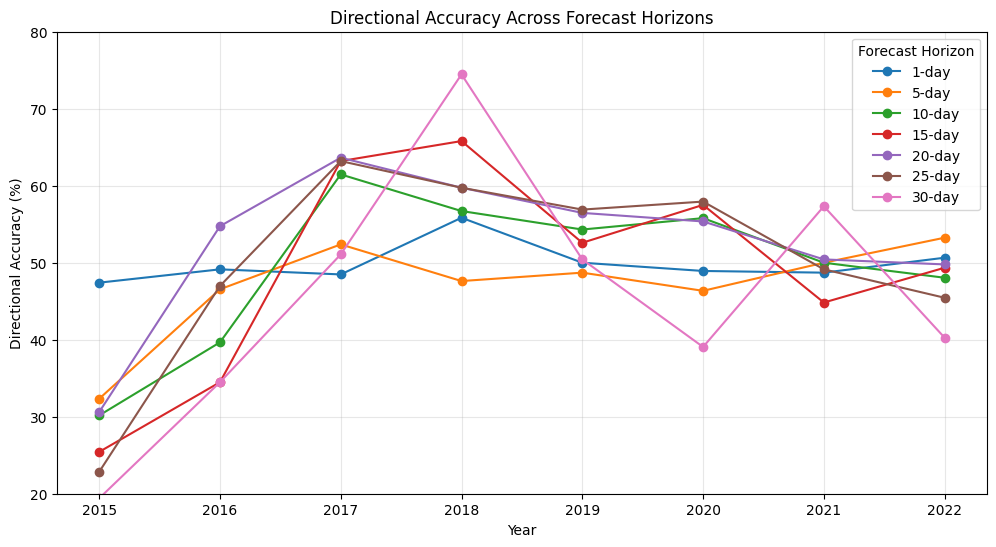

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_directional_accuracy(metrics_combined_2, seed=SEED)

In [ ]:
def plot_spearman(df: pd.DataFrame, seed=42):
    
    base_folder = "meta_analysis"
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    folder_name = os.path.join(base_folder, f"seed({seed})")
    os.makedirs(folder_name, exist_ok=True)
    
    plt.figure(figsize=(12,6))

    for horizon in  df.index.levels[0]:
        series = df.loc[horizon]["spearman"]
        plt.plot(
            series.index, 
            series.values, 
            marker="o", linestyle="--", 
            label=f"{horizon}-day"
        )

    plt.title("Spearman Information Coefficient by Prediction Horizon")
    plt.xlabel("Year")
    plt.ylabel("Spearman Correlation")
    plt.axhline(0, color="black", linewidth=1)
    plt.grid(True, alpha=0.3)
    plt.legend(title="Forecast Horizon", bbox_to_anchor=(1.02,1), loc="upper left")
    plt.tight_layout()
    plt.savefig(os.path.join(folder_name, f"Spearman_IC_seed{seed}_{timestamp}.png"), dpi=150)
    plt.show()
    
    return plt.gcf()

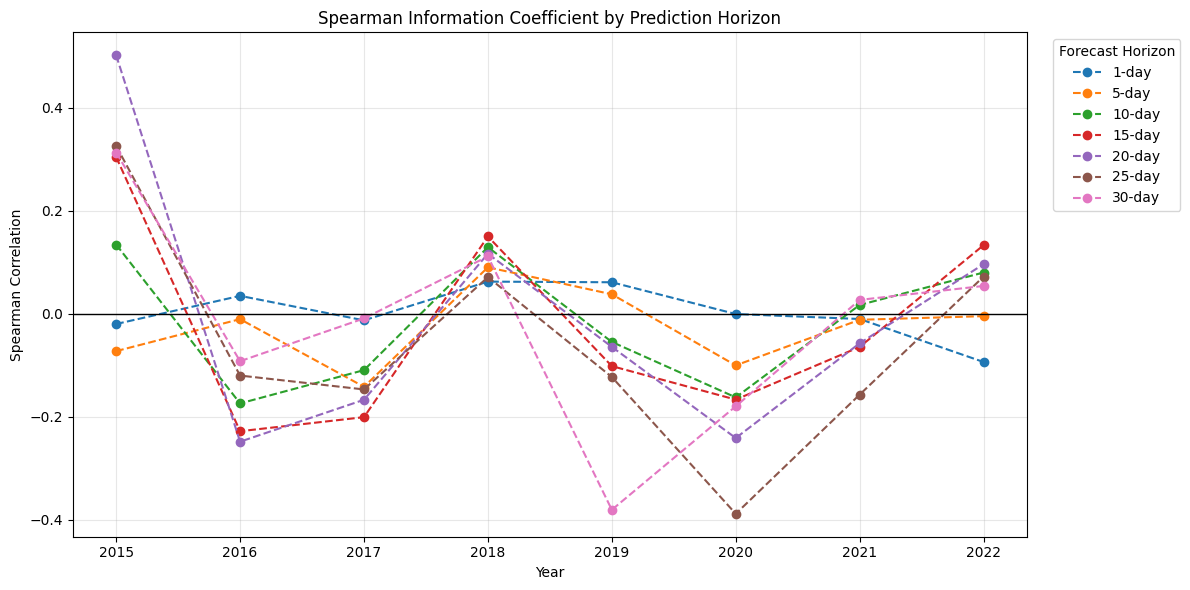

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_spearman(metrics_combined_2, seed=SEED)

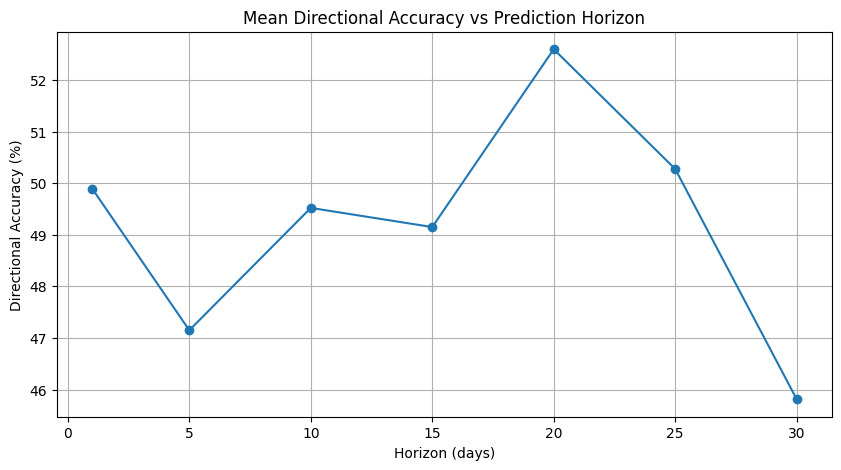

In [ ]:
plt.figure(figsize=(10,5))
summary = metrics_combined_2.groupby(level=0)["directional_accuracy (%)"].mean()
plt.plot(summary.index, summary.values, marker="o")
plt.title("Mean Directional Accuracy vs Prediction Horizon")
plt.xlabel("Horizon (days)")
plt.ylabel("Directional Accuracy (%)")
plt.grid(True)
plt.show()

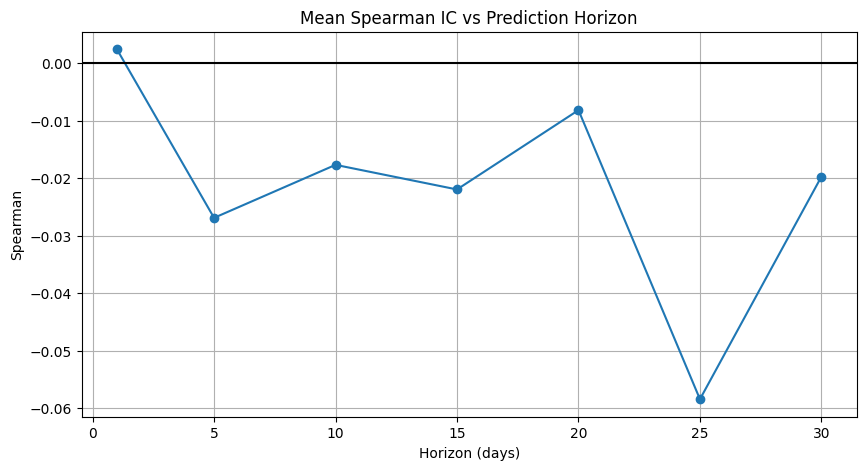

In [ ]:
summary_ic = metrics_combined_2.groupby(level=0)["spearman"].mean()
plt.figure(figsize=(10,5))
plt.plot(summary_ic.index, summary_ic.values, marker="o")
plt.title("Mean Spearman IC vs Prediction Horizon")
plt.xlabel("Horizon (days)")
plt.ylabel("Spearman")
plt.axhline(0, color="black")
plt.grid(True)
plt.show()

#### Backtest

to find the best horizon as the baseline for neuroevolutionary adaptation.
we already determined that within the range of 15-30 days there is more learnable structure in the market which a evolutionary strategy can exploit. To further explore this solutiona space and ensure that the evolutionary search will start from a more optimal region of the search space we will implement a simple backtest on what was statistically the more promising band of the prediction horizons (15 - 30 days) according to the DA + IC examination.

In [ ]:
def run_long_only_backtest(pred_df: pd.DataFrame, df: pd.DataFrame):
    """
    Computes passive buy-and-hold equity curve aligned with the prediction index.

    pred_df: returned from load_model_and_predict()
             must include prediction dates in its index
    
    df: the price dataframe with 'close' column
    
    Returns:
        DataFrame with:
            - buy_and_hold_return
            - buy_and_hold_equity
    """

    # Align price data to prediction period
    aligned_prices = df.loc[pred_df.index, "close"]

    # Compute daily log returns (same format as training target)
    daily_ret = np.log(aligned_prices / aligned_prices.shift(1)).fillna(0)

    # Cumulative performance
    cum_log_ret = daily_ret.cumsum()
    equity_curve = np.exp(cum_log_ret)  # convert back to multiplicative equity

    # Return formatted results dataframe
    backtest_df = pred_df.copy()
    backtest_df["buy_and_hold_return"] = daily_ret.values
    backtest_df["buy_and_hold_equity"] = equity_curve.values

    return backtest_df

In [ ]:
def run_model_strategy(pred_df: pd.DataFrame, horizon: int):
    """
    Converts model predictions into a trading equity curve.
    Uses daily return equivalent of the horizon-based log return.
    """

    # Long if model predicts positive return
    signal = (pred_df["prediction"] > 0).astype(int)

    # Convert horizon log return into daily equivalent
    # (because log returns scale linearly)
    daily_equiv_return = pred_df["actual"] / horizon  

    # Apply strategy
    strat_return = signal * daily_equiv_return

    # Compute equity curve
    equity_curve = np.exp(strat_return.cumsum())

    pred_df = pred_df.copy()
    pred_df["strategy_return"] = strat_return
    pred_df["strategy_equity"] = equity_curve

    return pred_df

In [ ]:
def get_spy_benchmark(pred_dates):
    spy = yf.Ticker("SPY").history(start=str(pred_dates.min().date()), end=str(pred_dates.max().date()))
    spy = spy["Close"].reindex(pred_dates).fillna(method="ffill")

    spy_ret = np.log(spy / spy.shift(1)).fillna(0)
    spy_equity = np.exp(spy_ret.cumsum())

    return spy_equity

In [ ]:
def plot_comparison(backtest_df, pred_df, horizon):
    
    plt.figure(figsize=(12,5))

    # Buy & Hold
    plt.plot(backtest_df.index, backtest_df["buy_and_hold_equity"],
             label="Buy & Hold (AMZN)", linewidth=2)

    # Model strategy
    plt.plot(pred_df.index, pred_df["strategy_equity"],
             label=f"Model Strategy ({horizon}-day)", linewidth=2)

    # # SPY Benchmark
    # spy_equity = get_spy_benchmark(pred_df.index)
    # plt.plot(pred_df.index, spy_equity,
    #          label="SPY Benchmark", linestyle="--")

    plt.title(f"Performance Comparison - {horizon}-Day Forecast Horizon")
    plt.xlabel("Date")
    plt.ylabel("Equity (normalized)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


=== Evaluating Horizon 15 ===


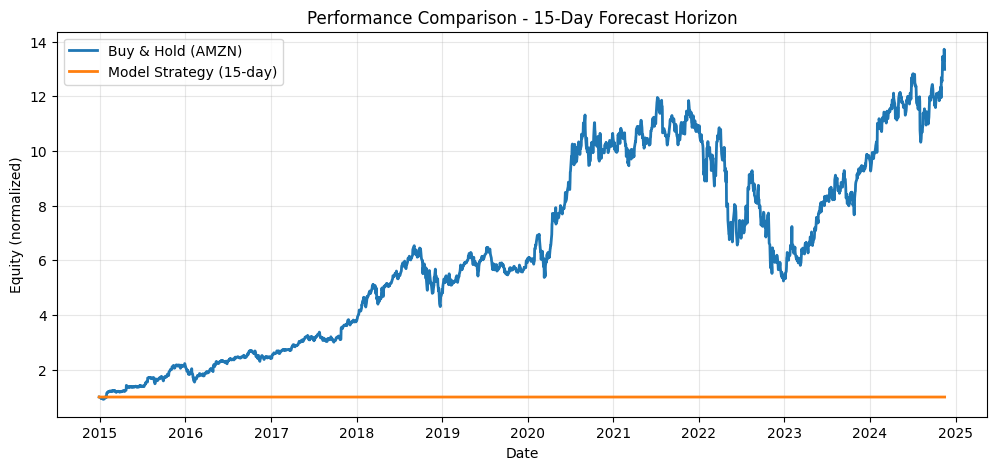


=== Evaluating Horizon 20 ===


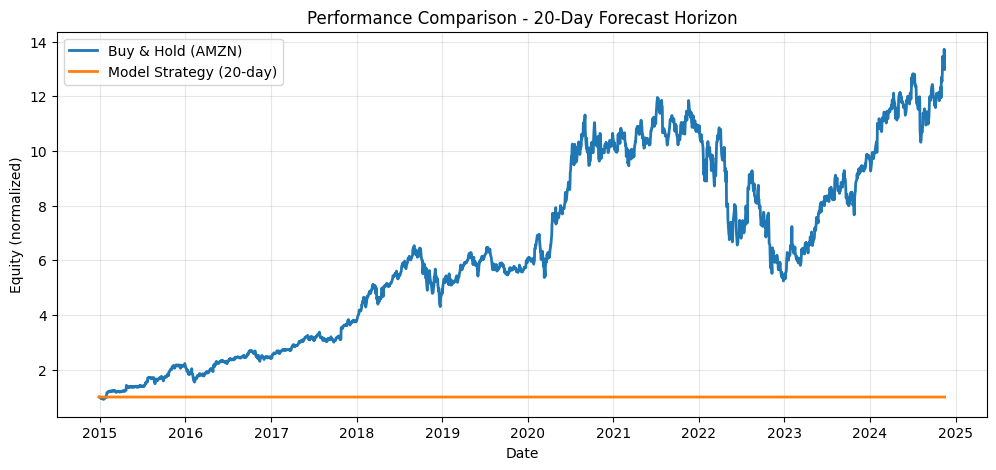


=== Evaluating Horizon 25 ===


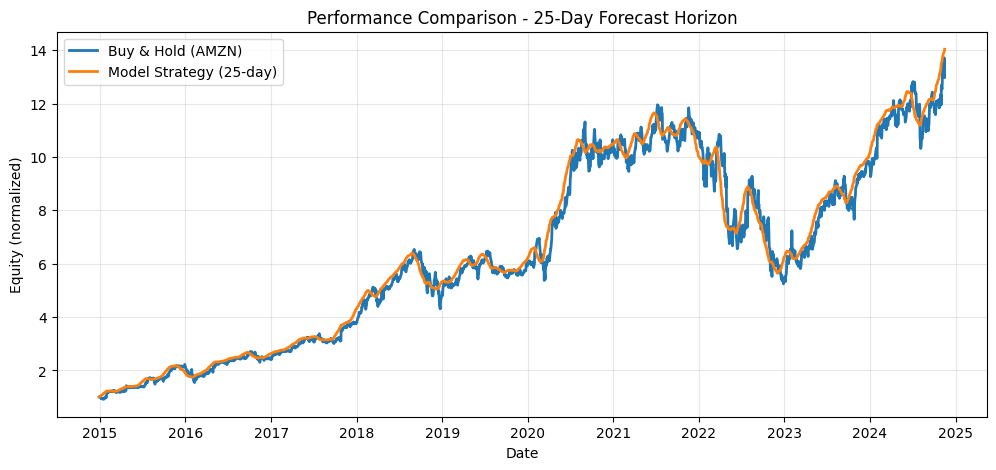


=== Evaluating Horizon 30 ===


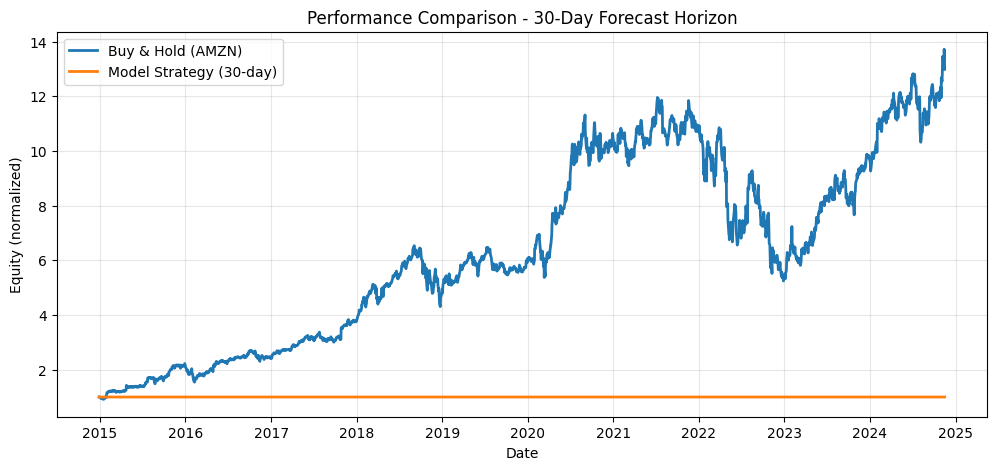

In [ ]:
prediction_targets = [15, 20, 25, 30]

for t in prediction_targets:

    print(f"\n=== Evaluating Horizon {t} ===")

    # Load predictions
    result = load_model_and_predict(t, df=multi_horizon_df)
    pred_df = result["predictions"]

    # Run Buy & Hold
    backtest_df = run_long_only_backtest(pred_df, multi_horizon_df)

    # Run model-based trading rule
    strat_df = run_model_strategy(pred_df, t)

    # Plot comparison
    plot_comparison(backtest_df, strat_df, t)

In [ ]:
for h in [15,20,25,30]:
    col = f"{h}_day_target"
    print(h, multi_horizon_df[col].isna().sum(), multi_horizon_df[col].nunique())

15 0 2509
20 0 2509
25 0 2509
30 0 2509


In [ ]:
for h in [15,20,25,30]:
    preds = load_model_and_predict(h, multi_horizon_df)["predictions"]["prediction"]
    print(f"\n--- {h}-DAY MODEL ---")
    print(preds.describe())
    print("Unique values:", preds.nunique())
    print("Pct > 0:", (preds > 0).mean())


--- 15-DAY MODEL ---
count    2489.00000
mean       -0.03137
std         0.00000
min        -0.03137
25%        -0.03137
50%        -0.03137
75%        -0.03137
max        -0.03137
Name: prediction, dtype: float64
Unique values: 1
Pct > 0: 0.0

--- 20-DAY MODEL ---
count    2489.000000
mean       -0.082546
std         0.000000
min        -0.082546
25%        -0.082546
50%        -0.082546
75%        -0.082546
max        -0.082546
Name: prediction, dtype: float64
Unique values: 1
Pct > 0: 0.0

--- 25-DAY MODEL ---
count    2489.000000
mean        0.015411
std         0.000000
min         0.015411
25%         0.015411
50%         0.015411
75%         0.015411
max         0.015411
Name: prediction, dtype: float64
Unique values: 1
Pct > 0: 1.0

--- 30-DAY MODEL ---
count    2489.000000
mean       -0.056846
std         0.000000
min        -0.056846
25%        -0.056846
50%        -0.056846
75%        -0.056846
max        -0.056846
Name: prediction, dtype: float64
Unique values: 1
Pct > 0: 

#### NEAT implementation of NeuroEvolutionary network